In [1]:
# General Imports
import math
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Ray Imports
from ray import tune
from ray.tune.registry import register_env
import ray.rllib.agents.ppo as ppo

# TT Imports
import tensortrade.env.default as default
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange,ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.feed.core import Stream, DataFeed
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Portfolio

---

### DRL Model

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [2]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    # 1. Data and TensorTrade Objects
    dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_train.csv')
    
    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange( name="B3", 
                            service=execute_order, 
                            options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # 2. Rewards

    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )
    
    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # 3. Actions - Managed Risk Orders
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # 4. Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    # 5. Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [3]:
window_size = 10

env_config_training = {
    # We want to look at the last N samples (days or hours)
    "window_size": window_size, # hours * days
    # And calculate reward based on the actions taken in the next 7 hours
    "reward_window_size": math.ceil(window_size / 2),
    # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "max_allowed_loss": 0.10,
}

analysis = tune.run(
    run_or_experiment="PPO",
    name="MyExperiment",
    metric="episode_reward_mean",
    mode="max",
    stop={
      "training_iteration": 5
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": window_size
        },
        "log_level": "WARNING",
        "framework": "tf2",
        "eager_tracing": True,
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },

    checkpoint_at_end=True
)

2022-05-16 16:26:43,810	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265
2022-05-16 16:26:53,979	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=16124) 2022-05-16 16:26:59,179	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.


 pid=6868) [<tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4430>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4580>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF46D0>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4730>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4880>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF49D0>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4B20>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4C70>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4DC0>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4F10>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA81FF4FD0>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA8204F1F0>, <tensortrade.feed.core.base.IterableStream object at 0x000001FA8204F340>, <tensortrade.feed.core.bas

Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=16124) 2022-05-16 16:27:08,019	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=6868) Quantity:  60000.00 BRL Price:  22.98 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85259.09 BRL Price:  21.56 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  78573.41 BRL Price:  19.53 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  38782.97 BRL Price:  11.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  81577.72 BRL Price:  9.56 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  94904.43 BRL Price:  8.56 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  110535.28 BRL Price:  11.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  72143.18 BRL Price:  11.85 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  125961.37 BRL Price:  13.71 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58845.67 BRL Price:  13.01 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  109594.43 BRL Price:  14.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  77823.68 BRL Price:  16.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  122474.58 BRL Price:  16.98 E

Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=6868) Quantity:  82704.39 BRL Price:  21.12 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  53335.49 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  67129.04 BRL Price:  21.34 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55851.24 BRL Price:  21.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  59924.34 BRL Price:  18.42 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  42176.34 BRL Price:  15.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  38655.36 BRL Price:  17.47 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  40325.77 BRL Price:  18.36 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  49826.69 BRL Price:  20.02 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  75058.90 BRL Price:  22.27 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  49292.40 BRL Price:  20.70 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66513.47 BRL Price:  22.56 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  67525.14 BRL Price:  20.71 Exc

Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=6868) Quantity:  93622.87 BRL Price:  22.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54588.00 BRL Price:  21.34 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  52911.32 BRL Price:  21.39 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55976.32 BRL Price:  16.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  97109.80 BRL Price:  17.40 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  94070.25 BRL Price:  17.95 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  111619.18 BRL Price:  19.21 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  60295.14 BRL Price:  20.83 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  112472.23 BRL Price:  21.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  94605.38 BRL Price:  20.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  124878.82 BRL Price:  22.07 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  57704.77 BRL Price:  20.96 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  90000.00 BRL Price:  22.97 

Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=6868) Quantity:  112211.23 BRL Price:  18.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  135595.46 BRL Price:  20.28 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  102619.34 BRL Price:  22.28 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  140210.58 BRL Price:  20.89 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  150361.27 BRL Price:  22.14 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  96964.22 BRL Price:  21.58 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  132443.98 BRL Price:  22.14 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  90000.00 BRL Price:  22.98 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  64468.94 BRL Price:  21.65 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  43118.35 BRL Price:  19.72 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56370.29 BRL Price:  11.20 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  44422.64 BRL Price:  9.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  40317.31 BRL Price:  10.7

Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


 pid=6868) Quantity:  72495.04 BRL Price:  22.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  115819.27 BRL Price:  20.88 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  62131.82 BRL Price:  22.80 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  120284.62 BRL Price:  21.71 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  113006.97 BRL Price:  21.58 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  52962.61 BRL Price:  22.47 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  90000.00 BRL Price:  22.98 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  46049.24 BRL Price:  21.75 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  52631.52 BRL Price:  19.53 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56837.46 BRL Price:  11.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  60952.91 BRL Price:  9.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  77687.26 BRL Price:  10.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  50588.41 BRL Price:  11.84 E

 pid=16124) 2022-05-16 16:27:30,213	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=16124) 2022-05-16 16:27:30,214	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


 pid=6868) Quantity:  61368.10 BRL Price:  11.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  81299.74 BRL Price:  13.05 Exchange Pair:  B3:BRL/ASSETS


Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


Trial name,status,loc
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124


Result for PPO_TradingEnv_24739_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-05-16_16-27-46
  done: false
  episode_len_mean: 435.0
  episode_media: {}
  episode_reward_max: 0.39619532860376616
  episode_reward_mean: 0.11423775804274522
  episode_reward_min: -0.23123240465991324
  episodes_this_iter: 9
  episodes_total: 9
  experiment_id: c07d09ad45024b938a4feb9b5cb4acb8
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 3.042724132537842
          entropy_coeff: 0.009999999776482582
          kl: 0.0017834485042840242
          policy_loss: -0.005979133304208517
          total_loss: 0.4050558805465698
          vf_explained_var: 0.03163064643740654
          vf_loss: 0.8822111487388611
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_sin

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


 pid=6868) Quantity:  61650.77 BRL Price:  15.61 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  79189.62 BRL Price:  15.03 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  93201.66 BRL Price:  14.62 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  103691.95 BRL Price:  19.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66466.63 BRL Price:  20.79 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  103853.57 BRL Price:  23.16 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54661.82 BRL Price:  21.12 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58148.27 BRL Price:  17.85 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  92431.51 BRL Price:  16.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  89499.23 BRL Price:  17.46 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  84755.52 BRL Price:  18.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  90789.33 BRL Price:  20.65 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  71981.21 BRL Price:  22.18 E

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


 pid=6868) Quantity:  101378.19 BRL Price:  20.47 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  72825.88 BRL Price:  23.17 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  117091.04 BRL Price:  21.34 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54948.93 BRL Price:  20.74 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  98201.09 BRL Price:  18.42 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  52696.18 BRL Price:  16.59 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  92063.73 BRL Price:  17.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  100360.28 BRL Price:  18.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  76503.95 BRL Price:  20.65 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  91802.82 BRL Price:  22.32 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  87107.16 BRL Price:  20.70 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  69026.82 BRL Price:  22.80 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55312.07 BRL Price:  20.54 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


 pid=6868) Quantity:  84547.50 BRL Price:  14.83 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55639.06 BRL Price:  17.91 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  68246.26 BRL Price:  20.13 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  51151.70 BRL Price:  22.39 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  98996.68 BRL Price:  21.67 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  44747.64 BRL Price:  15.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  79007.62 BRL Price:  17.33 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  42691.03 BRL Price:  18.41 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  42691.02 BRL Price:  18.36 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56197.81 BRL Price:  20.65 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58605.21 BRL Price:  22.45 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47142.43 BRL Price:  21.41 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47142.42 BRL Price:  20.38 Exc

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


 pid=6868) Quantity:  37640.15 BRL Price:  14.62 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  39758.39 BRL Price:  19.36 
 pid=6868) Exchange Pair: 
 pid=6868)  tWorker
 pid=6868) B3:BRL/ASSETS
 pid=6868) Quantity:  49366.55 BRL Price:  21.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  68656.78 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47645.27 BRL Price:  21.34 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  38240.91 BRL Price:  20.24 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47788.79 BRL Price:  17.57 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  53666.98 BRL Price:  16.59 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  40491.08 BRL Price:  17.72 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58824.31 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  88714.49 BRL Price:  22.27 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  49937.39 BRL Price:  20.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,1,38.36,4000,0.114238,0.396195,-0.231232,435


Result for PPO_TradingEnv_24739_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-05-16_16-28-23
  done: false
  episode_len_mean: 362.04761904761904
  episode_media: {}
  episode_reward_max: 0.39619532860376616
  episode_reward_mean: -0.020015186864612983
  episode_reward_min: -0.5489359809824718
  episodes_this_iter: 12
  episodes_total: 21
  experiment_id: c07d09ad45024b938a4feb9b5cb4acb8
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 0.000699999975040555
          entropy: 2.987114429473877
          entropy_coeff: 0.009999999776482582
          kl: 0.0510445199906826
          policy_loss: -0.1027042418718338
          total_loss: 0.0401650108397007
          vf_explained_var: 0.6429453492164612
          vf_loss: 0.3352718949317932
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    n

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


 pid=6868) Quantity:  69543.42 BRL Price:  19.21 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  37566.39 BRL Price:  22.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  50777.18 BRL Price:  21.25 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  77238.18 BRL Price:  20.91 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  70000.00 BRL Price:  22.82 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47151.06 BRL Price:  21.75 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47151.06 BRL Price:  21.72 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85392.69 BRL Price:  18.79 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54429.24 BRL Price:  11.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  67189.92 BRL Price:  9.05 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  37864.80 BRL Price:  10.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  42327.08 BRL Price:  10.13 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  33197.69 BRL Price:  12.67 Exch

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


 pid=6868) Quantity:  127682.64 BRL Price:  17.36 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  133381.71 BRL Price:  17.07 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  60832.21 BRL Price:  15.61 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  70770.01 BRL Price:  15.03 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  112779.79 BRL Price:  17.28 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  84927.15 BRL Price:  18.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  89767.30 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  72426.52 BRL Price:  21.96 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  69666.62 BRL Price:  20.27 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  109590.61 BRL Price:  16.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  65040.57 BRL Price:  17.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  65040.56 BRL Price:  17.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  98731.18 BRL Price:  19.42

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


 pid=6868) Quantity:  66984.29 BRL Price:  17.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  39939.08 BRL Price:  16.32 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  53729.00 BRL Price:  14.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58611.93 BRL Price:  14.51 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56249.39 BRL Price:  16.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85282.82 BRL Price:  19.70 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  91049.22 BRL Price:  20.47 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  98893.50 BRL Price:  23.16 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  83802.92 BRL Price:  21.09 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66762.64 BRL Price:  17.57 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  42009.87 BRL Price:  16.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  36601.80 BRL Price:  17.40 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  60798.01 BRL Price:  18.52 Exc

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


 pid=6868) Quantity:  92005.58 BRL Price:  15.61 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  96610.61 BRL Price:  14.79 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  63704.02 BRL Price:  14.19 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  50161.80 BRL Price:  16.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  63174.54 BRL Price:  19.58 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54859.75 BRL Price:  21.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54859.74 BRL Price:  21.21 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  58755.92 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  100821.96 BRL Price:  21.12 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  53480.87 BRL Price:  15.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  84984.38 BRL Price:  17.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  81668.54 BRL Price:  18.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54676.60 BRL Price:  20.46 Ex

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,2,75.4507,8000,-0.0200152,0.396195,-0.548936,362.048


Result for PPO_TradingEnv_24739_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-05-16_16-29-04
  done: false
  episode_len_mean: 360.6969696969697
  episode_media: {}
  episode_reward_max: 0.6194905399033873
  episode_reward_mean: 0.008083097383570189
  episode_reward_min: -0.5727874033306771
  episodes_this_iter: 12
  episodes_total: 33
  experiment_id: c07d09ad45024b938a4feb9b5cb4acb8
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 0.0003000000142492354
          entropy: 2.9234964847564697
          entropy_coeff: 0.009999999776482582
          kl: 0.033694274723529816
          policy_loss: -0.1168823167681694
          total_loss: -0.04113411158323288
          vf_explained_var: 0.8018118143081665
          vf_loss: 0.19985805451869965
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 120

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


 pid=6868) Quantity:  59355.06 BRL Price:  16.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  83030.98 BRL Price:  16.98 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  48448.03 BRL Price:  14.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  50101.04 BRL Price:  14.62 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  74088.85 BRL Price:  17.28 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  71044.18 BRL Price:  19.41 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85710.05 BRL Price:  21.21 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  113159.89 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  92332.31 BRL Price:  21.12 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  65303.31 BRL Price:  18.42 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  59784.34 BRL Price:  16.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47283.44 BRL Price:  17.40 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  82415.06 BRL Price:  18.38 Ex

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


 pid=6868) Quantity:  138656.88 BRL Price:  15.60 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  119117.72 BRL Price:  17.01 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  83289.76 BRL Price:  15.15 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  133593.93 BRL Price:  15.32 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  62823.22 BRL Price:  15.49 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  95461.89 BRL Price:  14.19 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66645.21 BRL Price:  16.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  139127.47 BRL Price:  17.81 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  106319.77 BRL Price:  19.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  143896.73 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  104108.15 BRL Price:  21.96 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  150211.53 BRL Price:  20.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  80887.54 BRL Price:  1

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


 pid=6868) Quantity:  71326.06 BRL Price:  17.19 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  97605.27 BRL Price:  16.23 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54284.21 BRL Price:  15.33 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  61072.30 BRL Price:  14.93 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66530.86 BRL Price:  14.51 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  54727.79 BRL Price:  16.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  86969.28 BRL Price:  18.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  93660.17 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56468.71 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  96897.28 BRL Price:  21.34 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  71197.75 BRL Price:  20.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  77851.24 BRL Price:  17.85 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  64400.34 BRL Price:  16.59 Exc

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


 pid=6868) Quantity:  86646.01 BRL Price:  14.51 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  67990.40 BRL Price:  17.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  102813.27 BRL Price:  18.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55801.11 BRL Price:  19.97 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55801.11 BRL Price:  19.92 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  120574.09 BRL Price:  22.39 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  101501.85 BRL Price:  20.17 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  107699.54 BRL Price:  21.39 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47082.16 BRL Price:  16.78 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  47082.16 BRL Price:  16.64 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  60603.81 BRL Price:  17.72 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  73902.66 BRL Price:  19.44 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  55285.14 BRL Price:  21.73

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


 pid=6868) Quantity:  71288.09 BRL Price:  14.19 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  90468.43 BRL Price:  17.28 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  74357.71 BRL Price:  17.50 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  118967.49 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  71726.70 BRL Price:  21.12 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  71726.70 BRL Price:  20.64 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  78522.18 BRL Price:  16.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  83193.10 BRL Price:  17.40 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  125197.70 BRL Price:  18.52 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  81803.28 BRL Price:  20.07 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  142485.74 BRL Price:  21.87 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  133920.72 BRL Price:  20.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85976.83 BRL Price:  22.01

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,3,115.957,12000,0.0080831,0.619491,-0.572787,360.697


Result for PPO_TradingEnv_24739_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-05-16_16-29-45
  done: false
  episode_len_mean: 369.0232558139535
  episode_media: {}
  episode_reward_max: 0.6194905399033873
  episode_reward_mean: 0.05878753858903591
  episode_reward_min: -0.5727874033306771
  episodes_this_iter: 10
  episodes_total: 43
  experiment_id: c07d09ad45024b938a4feb9b5cb4acb8
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.22499999403953552
          cur_lr: 9.7999996796716e-05
          entropy: 2.883568048477173
          entropy_coeff: 0.009999999776482582
          kl: 0.018947064876556396
          policy_loss: -0.09012916684150696
          total_loss: -0.014884473755955696
          vf_explained_var: 0.7945982813835144
          vf_loss: 0.19963456690311432
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


 pid=6868) Quantity:  93481.95 BRL Price:  11.85 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  80717.93 BRL Price:  13.71 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  66918.54 BRL Price:  14.63 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  80864.35 BRL Price:  16.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  64623.85 BRL Price:  16.98 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  102341.83 BRL Price:  15.15 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  86332.35 BRL Price:  15.03 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  89617.78 BRL Price:  14.51 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  100460.51 BRL Price:  18.66 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  53808.60 BRL Price:  20.31 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  78899.32 BRL Price:  23.16 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  86481.98 BRL Price:  22.15 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  91723.53 BRL Price:  20.17 E

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


 pid=6868) Quantity:  52069.88 BRL Price:  16.49 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  67685.83 BRL Price:  14.64 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  62525.67 BRL Price:  16.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  109685.89 BRL Price:  17.81 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  107769.64 BRL Price:  19.08 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  127853.03 BRL Price:  20.76 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  136928.06 BRL Price:  22.86 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  87810.32 BRL Price:  20.17 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  105120.66 BRL Price:  21.39 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  95858.69 BRL Price:  17.85 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  79296.50 BRL Price:  15.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85574.15 BRL Price:  17.33 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  56936.02 BRL Price:  18.3

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


 pid=6868) Quantity:  104909.55 BRL Price:  16.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  98227.80 BRL Price:  17.81 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  134399.51 BRL Price:  18.90 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  144739.62 BRL Price:  21.18 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  85605.52 BRL Price:  23.10 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  114251.27 BRL Price:  20.75 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  138852.34 BRL Price:  17.40 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  134506.39 BRL Price:  18.36 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  97618.66 BRL Price:  20.11 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  135859.55 BRL Price:  21.87 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  96994.56 BRL Price:  20.38 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  101068.13 BRL Price:  22.01 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  80518.83 BRL Price:  2

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


 pid=6868) Quantity:  149967.54 BRL Price:  18.42 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  93887.16 BRL Price:  15.84 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  100390.79 BRL Price:  17.33 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  75757.63 BRL Price:  17.95 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  94338.29 BRL Price:  19.42 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  147339.59 BRL Price:  21.87 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  123882.93 BRL Price:  20.70 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  147254.03 BRL Price:  22.69 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  108397.41 BRL Price:  21.71 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  148295.20 BRL Price:  20.19 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  144348.82 BRL Price:  22.30 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  80000.00 BRL Price:  22.72 Exchange Pair:  B3:BRL/ASSETS
 pid=6868) Quantity:  75049.23 BRL Price:  2

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,RUNNING,127.0.0.1:16124,4,156.947,16000,0.0587875,0.619491,-0.572787,369.023


Result for PPO_TradingEnv_24739_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-05-16_16-30-24
  done: true
  episode_len_mean: 380.4423076923077
  episode_media: {}
  episode_reward_max: 0.6194905399033873
  episode_reward_mean: 0.11718585039491683
  episode_reward_min: -0.5727874033306771
  episodes_this_iter: 9
  episodes_total: 52
  experiment_id: c07d09ad45024b938a4feb9b5cb4acb8
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.22499999403953552
          cur_lr: 9.40000027185306e-05
          entropy: 2.84364914894104
          entropy_coeff: 0.009999999776482582
          kl: 0.02032904140651226
          policy_loss: -0.09349851310253143
          total_loss: -0.018391599878668785
          vf_explained_var: 0.7916176319122314
          vf_loss: 0.1979387253522873
    num_agent_steps_sampled: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
   

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_24739_00000,TERMINATED,127.0.0.1:16124,5,196.365,20000,0.117186,0.619491,-0.572787,380.442


2022-05-16 16:30:25,364	INFO tune.py:626 -- Total run time: 211.63 seconds (210.81 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [4]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": window_size # We want to look at the last x samples (days)
        },
        "framework": "tf2",
        "eager_tracing": False,
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0.5,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)

agent.restore(checkpoint_path)

2022-05-16 16:30:25,455	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=9568) 2022-05-16 16:30:31,163	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=9568) 2022-05-16 16:30:31,210	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=9568) 2022-05-16 16:30:31,216	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000002AB21DD1AF0>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=9568)   -inf -inf -inf -inf -inf -inf]
 pid=9568)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 pid=9568)   -inf -inf -inf -inf -inf -inf]
 pid=9568)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -in

 pid=9568) [<tensortrade.feed.core.base.IterableStream object at 0x000002AB21737490>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB217375E0>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737730>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737790>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB217378E0>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737A30>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737B80>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737CD0>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737E20>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21737F70>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21DD1100>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21DD1250>, <tensortrade.feed.core.base.IterableStream object at 0x000002AB21DD13A0>, <tensortrade.feed.core.bas

2022-05-16 16:30:32,668	INFO worker_set.py:104 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
  -inf -inf -inf -inf -inf -inf]
 [-in

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [5]:
# Restore agent
agent.restore(checkpoint_path)

# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

2022-05-16 16:30:37,481	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\MyExperiment\PPO_TradingEnv_24739_00000_0_2022-05-16_16-26-53\checkpoint_000005\checkpoint-5
2022-05-16 16:30:37,482	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': 0, '_time_total': 196.36532378196716, '_episodes_total': 52}


[<tensortrade.feed.core.base.IterableStream object at 0x0000026111561FD0>, <tensortrade.feed.core.base.IterableStream object at 0x000002610ECA6820>, <tensortrade.feed.core.base.IterableStream object at 0x000002611149A820>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E0D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E550>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E280>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E0A0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5EA60>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E880>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C5E850>, <tensortrade.feed.core.base.IterableStream object at 0x0000026111C21F70>, <tensortrade.feed.core.base.IterableStream object at 0x00000261114CF430>, <tensortrade.feed.core.base.IterableStream object at 0x00000261114CF0A0>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

---

### Validation Set

In [6]:
def create_eval_env(config):
    """Creates the Evaluation Environment."""
    dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')

    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    print (features)
    feed = DataFeed(features)
    feed.compile()
    
    # Rewards - Risk Adjusted Returns
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # Actions
    action_scheme = default.actions.ManagedRiskOrders(
        stop=[0.05],
        take=[0.075],
        min_order_pct=0.5
    )

    # A discrete action scheme that determines actions based on managing risk
    # action_scheme = default.actions.ManagedRiskOrders()
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset['date'])).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment, portfolio

In [7]:
# 1. Instantiate the evaluation environment
env, portfolio = create_eval_env({
    "window_size": window_size
})

# 2. Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

[<tensortrade.feed.core.base.IterableStream object at 0x00000263039960D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996220>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996370>, <tensortrade.feed.core.base.IterableStream object at 0x00000263039963D0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996520>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996670>, <tensortrade.feed.core.base.IterableStream object at 0x00000263039967C0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996910>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996A60>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996BB0>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996D00>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996E50>, <tensortrade.feed.core.base.IterableStream object at 0x0000026303996FA0>, <tensortrade.feed.core.base.IterableS

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),70000.00 BRL,30000.00 BRL,70000.00 BRL,70000.00 BRL
1,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),245.00 BRL,30000.00 BRL,69755.00 BRL,69755.00 BRL
2,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),69755.00 BRL,30000.00 BRL,0.00 BRL,0.00 BRL
3,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3,B3:ASSETS/locked,DEPOSIT (TRADED 69755.00 BRL B3:BRL/ASSETS @ 2...,2904.04 ASSETS,0.00 ASSETS,2904.04 ASSETS,2904.04 ASSETS
4,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),10.16 ASSETS,0.00 ASSETS,2893.88 ASSETS,2893.88 ASSETS
5,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),2893.88 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3,B3:BRL/locked,DEPOSIT (TRADED 2893.88 ASSETS B3:BRL/ASSETS @...,64967.61 BRL,30000.00 BRL,64967.61 BRL,64967.61 BRL
7,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),64967.61 BRL,94967.61 BRL,0.00 BRL,0.00 BRL
8,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,88487e1f-0399-43f9-af91-e0ef927e3d7c,15,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),47483.81 BRL,47483.80 BRL,47483.81 BRL,47483.81 BRL


In [8]:
portfolio.ledger.as_frame().head(10)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),70000.00 BRL,30000.00 BRL,70000.00 BRL,70000.00 BRL
1,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),245.00 BRL,30000.00 BRL,69755.00 BRL,69755.00 BRL
2,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),69755.00 BRL,30000.00 BRL,0.00 BRL,0.00 BRL
3,d63bcea0-38a5-4139-8e0f-823b41b739c7,6,B3,B3:ASSETS/locked,DEPOSIT (TRADED 69755.00 BRL B3:BRL/ASSETS @ 2...,2904.04 ASSETS,0.00 ASSETS,2904.04 ASSETS,2904.04 ASSETS
4,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3,WITHDRAWAL (COMMISSION),10.16 ASSETS,0.00 ASSETS,2893.88 ASSETS,2893.88 ASSETS
5,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3,WITHDRAWAL (FILL ORDER),2893.88 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
6,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3,B3:BRL/locked,DEPOSIT (TRADED 2893.88 ASSETS B3:BRL/ASSETS @...,64967.61 BRL,30000.00 BRL,64967.61 BRL,64967.61 BRL
7,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:BRL/locked,B3:BRL/free,UNLOCK BRL (COMPLETED),64967.61 BRL,94967.61 BRL,0.00 BRL,0.00 BRL
8,d63bcea0-38a5-4139-8e0f-823b41b739c7,13,B3:ASSETS/locked,B3:ASSETS/free,UNLOCK ASSETS (COMPLETED),0.00 ASSETS,0.00 ASSETS,0.00 ASSETS,0.00 ASSETS
9,88487e1f-0399-43f9-af91-e0ef927e3d7c,15,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),47483.81 BRL,47483.80 BRL,47483.81 BRL,47483.81 BRL


In [9]:
df = pd.DataFrame(portfolio.performance)

<AxesSubplot:>

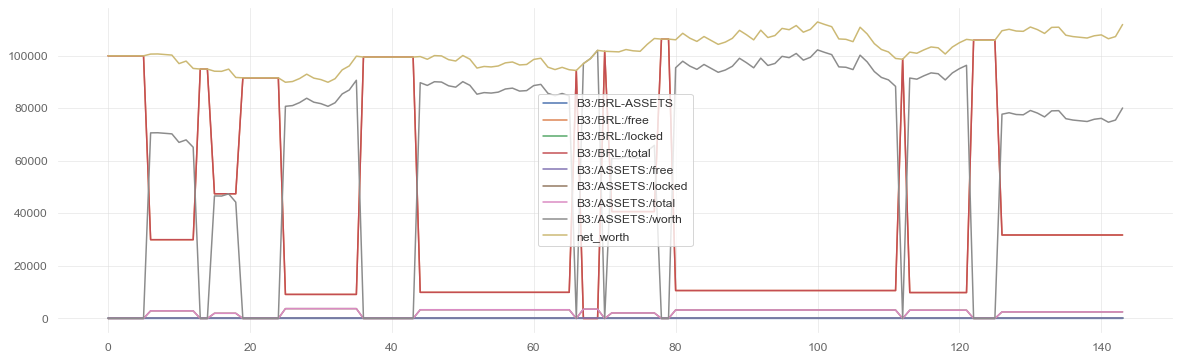

In [19]:
df.T.plot(figsize=(20,6))

<AxesSubplot:>

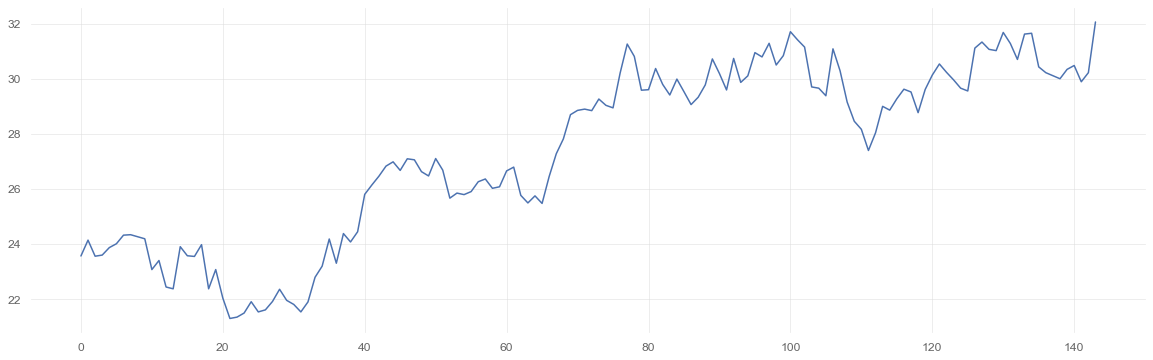

In [20]:
df.loc["B3:/BRL-ASSETS"].plot(figsize=(20,6))

<AxesSubplot:>

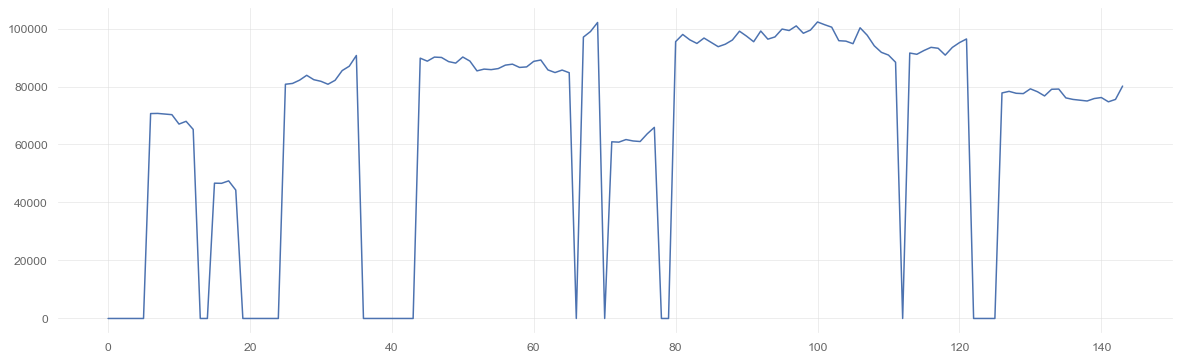

In [21]:
df.loc["B3:/ASSETS:/worth"].plot(figsize=(20,6))

---

### Net Worth Analysis (with Quantstats)

In [13]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [14]:
dataset = pd.read_csv('../../data/market/ohlcv_daily_TA/PETR3_test.csv')

net_worth = df.loc["net_worth"].rename('close')
net_worth.index = dataset['date'].loc[:]
net_worth.index = pd.to_datetime(net_worth.index)

net_worth = net_worth.resample('D').last()
net_worth.index = net_worth.index.date
net_worth.index = net_worth.index.rename('date')

In [15]:
net_returns = net_worth.pct_change().dropna()
net_returns.index = pd.to_datetime(net_returns.index)
net_returns

date
2021-10-05    0.000000
2021-10-06    0.000000
2021-10-07    0.000000
2021-10-08    0.000000
2021-10-09    0.000000
                ...   
2022-04-30    0.000000
2022-05-01    0.000000
2022-05-02   -0.013655
2022-05-03    0.007743
2022-05-04    0.042843
Name: close, Length: 212, dtype: float64

In [16]:
# show sharpe ratio
qs.stats.sharpe(net_returns)

0.7315428020208798

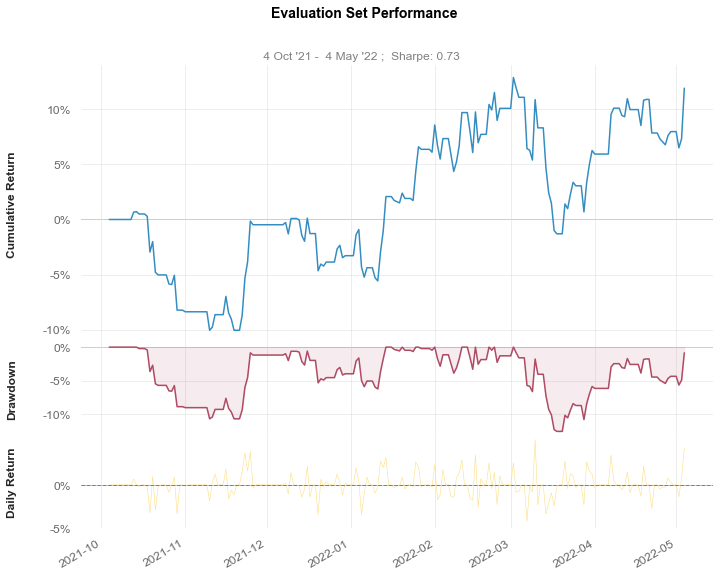

In [17]:
# Show overall performance
qs.plots.snapshot(net_returns, title=f'Evaluation Set Performance')

In [18]:
# Convert datetime to date (keep end of day result)
qs.reports.html(net_returns, "^BVSP")

---